In [2]:
import numpy as np
import pandas as pd
from scipy import stats as ss
import seaborn as sns
import sklearn
from matplotlib import pyplot as plt

In [3]:
sns.set_style('darkgrid')

# Part 1: Proof of Concept

1. Generate simple data that can be used for logistic regression X-> Y with known parameters
2. Generate logistic regression parameters $\hat{\beta}$ and true signal $\beta$. 
3. Plot

In [4]:
from sklearn.linear_model import LogisticRegression, LinearRegression

In [78]:
#1 simple data X-> Y

def generate_logistic(events_per_var, y_func, num_dim=1):
    xs = ss.uniform.rvs(size=(events_per_var*num_dim, num_dim))
    ys = y_func(xs).flatten()
    
    if (ys.sum() == 0):
        return 0
    elif (ys.sum() == len(ys)):
        return 1
    else:
        clf = LogisticRegression( fit_intercept=False
                                ).fit(xs, ys)
    
    return clf.coef_.flatten()[0]

generate_logistic( events_per_var=100
                 , y_func=lambda x : (x > .4).astype(int)
                 , num_dim=1
                 )

1.7896055274614724

In [79]:
np.arange(10, 100, 10)

array([10, 20, 30, 40, 50, 60, 70, 80, 90])

In [80]:
n = 1000
# epv = 100
dfs = []
for epv in np.arange(10, 100, 10):
    beta_true = ss.uniform.rvs(size=n)
    beta_est  = [generate_logistic( epv
                                  , lambda x : (x > beta).astype(int)
                                  , num_dim=1
                                  )
                 for beta in beta_true]
    dfs.append(pd.DataFrame({ 'estimated':beta_est
                            , 'true' : beta_true
                            , 'epv' : epv})
              )
df = pd.concat(dfs)

<AxesSubplot:xlabel='estimated', ylabel='true'>

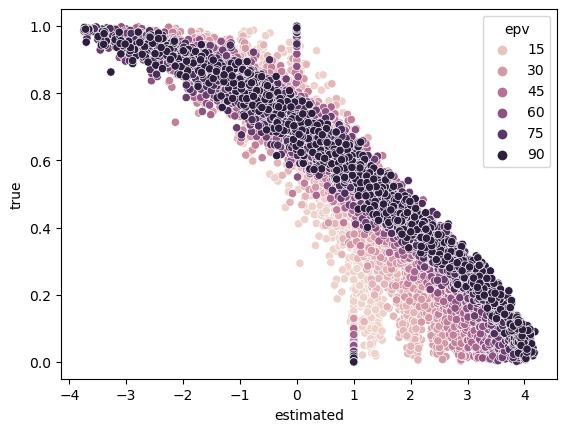

In [81]:
sns.scatterplot(data=df, x='estimated', y="true", hue='epv')

# Part 2: Test out the double-sampling scheme with generated data

1. Generate population data
2. Extract sample data
3. Do logistic regressions on both to extract parameters

In [172]:
def double_sample_scheme(population_size, sample_size, y_function, n_dims=1, use_intercept=False):
    
    # population (outer sample)
    p_xs = ss.uniform.rvs(size=(population_size, n_dims))
    p_ys = y_function(p_xs).flatten()
    p_inds = np.arange(1,len(p_ys))  
    
    if p_ys.sum() == 0:
        p_coeff=[np.nan]
        
        if use_intercept:
            p_coeff += [np.nan]
            
    elif p_ys.sum() == len(p_ys):
        p_coeff=[np.nan]
         
        if use_intercept:
            p_coeff += [np.nan]
    
    else:    
        p_mdl = LogisticRegression( fit_intercept=use_intercept
                                  ).fit( p_xs
                                       , p_ys
                                       )
        p_coeff = [x for x in p_mdl.coef_.flatten()]
    
        if use_intercept:
            p_coeff += [x for x in p_mdl.intercept_]

    
    # sample (inner sample)
    s_inds = np.random.choice( p_inds
                             , size=sample_size
                             , replace=False
                             )
    s_xs = p_xs[s_inds]
    s_ys = p_ys[s_inds]
    
    if s_ys.sum() == 0:
        s_coeff=[np.nan]
        
        if use_intercept:
            s_coeff += [np.nan]
            
    elif s_ys.sum() == len(s_ys):
        s_coeff=[np.nan]
         
        if use_intercept:
            s_coeff += [np.nan]
    
    else:
        s_mdl = LogisticRegression( fit_intercept=use_intercept
                                  ).fit( s_xs
                                       , s_ys
                                       )
        s_coeff = [x for x in s_mdl.coef_.flatten()] 
        
        if use_intercept:
            s_coeff += [x for x in s_mdl.intercept_]
    
    return ( p_coeff
           , s_coeff
           )


In [173]:
double_sample_scheme( population_size=1000
                    , sample_size=100
                    , y_function=lambda x : (x > .5).astype(int)
                    , n_dims=1
                    , use_intercept=False)

([1.628915190806502], [1.5972292921534172])

# Part 3: Double-sample experiment in 1-d using generated data. 

1. Generate "asymptotic statistics" aka a semi-random spread over proportions for a specified EPV
2. Examine population vs sample logistic regression parameters. 
3. Examine and correct the bias. 

In [318]:
def one_d_experiment(population_size, sample_size, noise_size=5):
    proportion = np.arange(.1, .9, .01)
    d = { 'population' : []
        , 'sample' : []
        , 'proportion' : []
        , 'epv' : []
    }
    for p in proportion:
        noise = ss.uniform.rvs(size=5) * 0.01
        for n in noise:
            p_beta, s_beta = double_sample_scheme( population_size=population_size
                                                 , sample_size=sample_size
                                                 , y_function=lambda x : (x > (p + n)).astype(int)
                                                 , n_dims=1
                                                 , use_intercept=False)
            d['population'].append(p_beta)
            d['sample'].append(s_beta)
            d['proportion'].append(p+n)
            d['epv'].append(sample_size / 1)

    df = pd.DataFrame(d)
    df = df.explode('population').explode('sample')
    df['bias'] = df['sample'] - df['population']
    
    df = df.dropna()

    linreg = LinearRegression(fit_intercept=False).fit( df['population'].values.reshape(-1, 1)
                                                      , df['sample'].values
                                                      )
    
    df['correction'] = df['sample'] - linreg.coef_[0] * df['population']
    
    df_1 = df.copy()
    df_1['corrected'] = False
    df_2 = df.copy()
    df_2['bias'] = df['correction']
    df_2['corrected'] = True

    df_j = pd.concat([df_1, df_2], axis=0).drop(columns=['correction']).reset_index()
    
    # plots
    
    sns.jointplot( data=df
                   , x='population'
                   , y='sample'
                   )
    plt.show()
    
#     sns.histplot( data=df
#                 , x='bias'
#                 , color='red'
#                 , label=r'$\hat{\beta} - \beta$' 
#                 )
#     sns.histplot( data=df
#                 , x='correction'
#                 , color='skyblue'
#                 , label=r'$\hat{\beta} - \alpha_*\beta$' 
#                 )
#     plt.legend()

    sns.histplot(data=df_j
                , x='bias'
                , hue='corrected'
                , palette=['red', 'skyblue'] 
                )
    plt.show()

    

    sns.jointplot( data=df_j
                 , x='population'
                 , y='bias'
                 , hue='corrected'
                 , palette=['red', 'skyblue'] 
                 )
    plt.show()
    
    return df

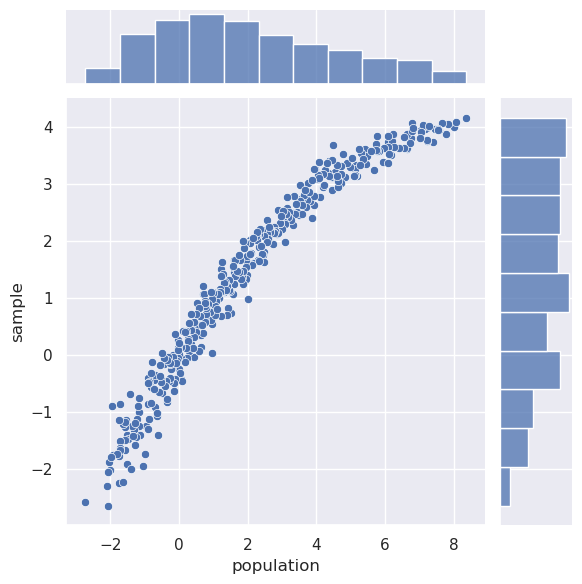

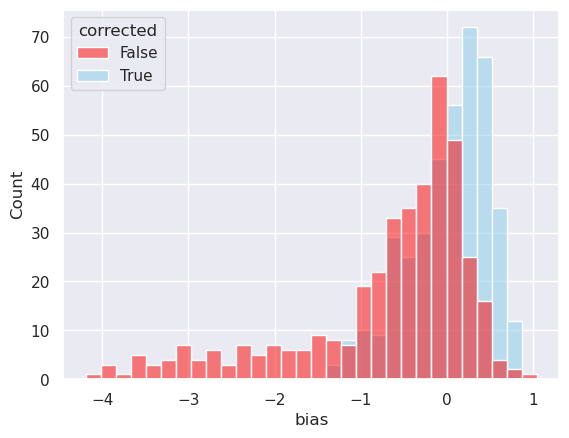

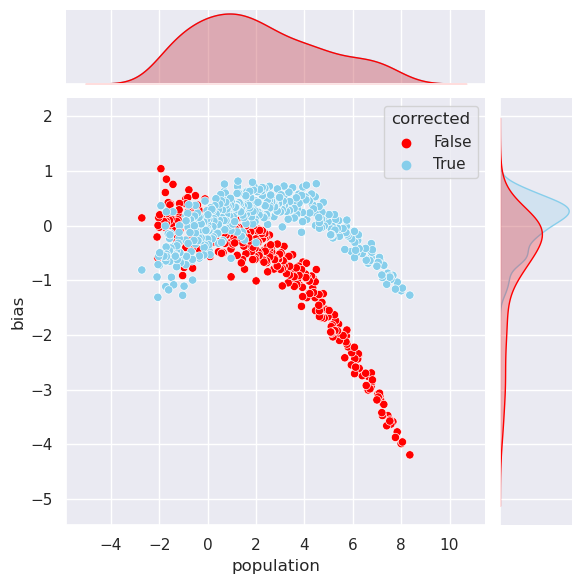

In [320]:
df = one_d_experiment( population_size=1000
                     , sample_size=100
                     , noise_size=50
                     )

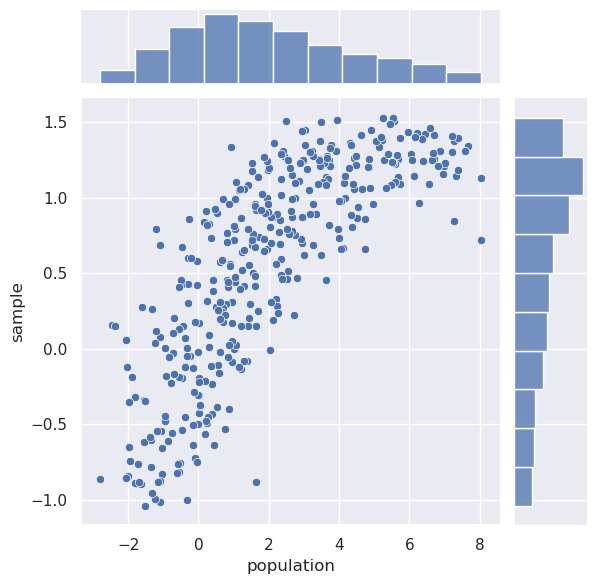

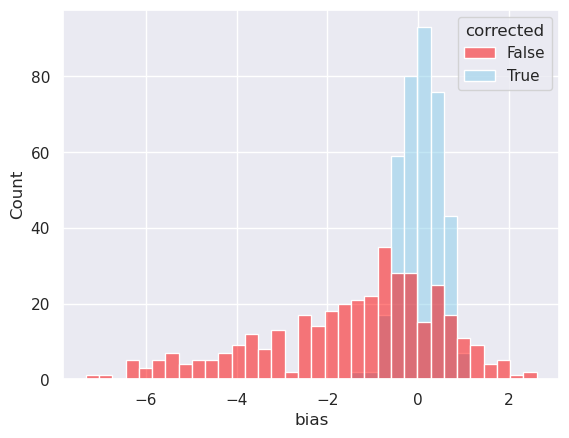

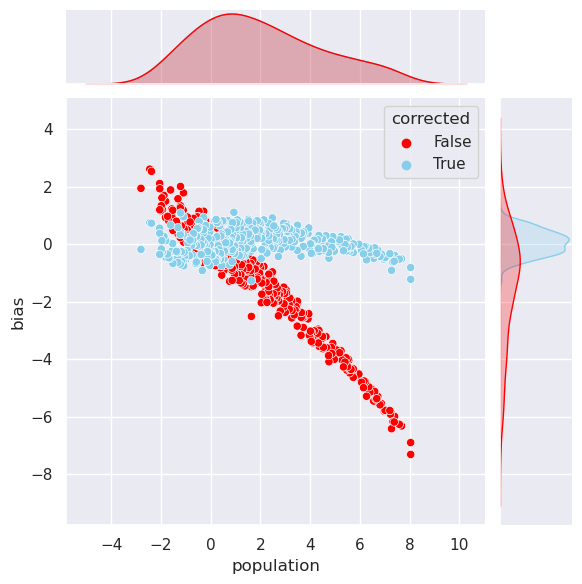

,population,sample,proportion,epv,bias,correction
0,8.036366,1.13032,0.104455,10.0,-6.906046,-0.812473
1,7.671119,1.344824,0.107148,10.0,-6.326295,-0.509671
2,8.038539,0.719197,0.100999,10.0,-7.319342,-1.224121
5,7.262296,1.37398,0.118542,10.0,-5.888316,-0.381681
8,7.389847,1.395186,0.113401,10.0,-5.994661,-0.391311
...,...,...,...,...,...,...
394,-1.987475,-0.648799,0.887506,10.0,1.338675,-0.168327
395,-2.450939,0.160198,0.892254,10.0,2.611137,0.752713
396,-2.804908,-0.861078,0.899568,10.0,1.943831,-0.18299
397,-2.050779,-0.852661,0.896432,10.0,1.198118,-0.356885


In [321]:
one_d_experiment( population_size=1000
                , sample_size=10
                , noise_size=50
                )

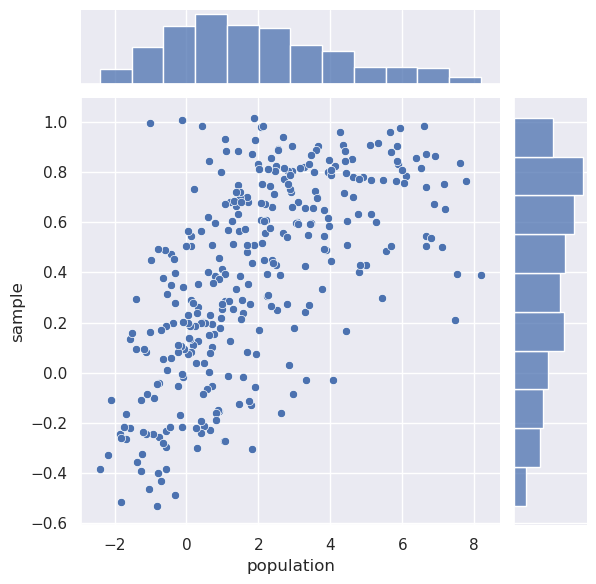

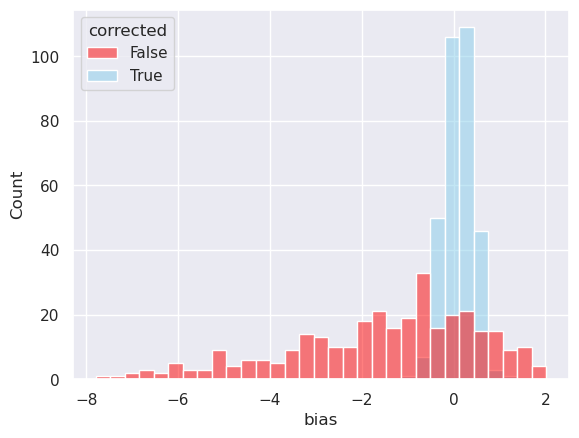

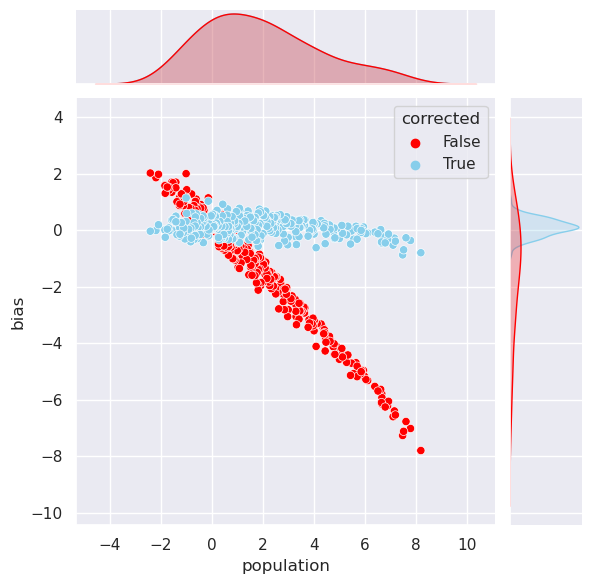

,population,sample,proportion,epv,bias,correction
1,7.782794,0.764484,0.105400,5.0,-7.01831,-0.363437
4,8.188177,0.38952,0.102414,5.0,-7.798657,-0.797152
9,7.606133,0.834316,0.113749,5.0,-6.771816,-0.268002
11,7.475647,0.209105,0.122695,5.0,-7.266541,-0.874303
14,7.514156,0.394844,0.120509,5.0,-7.119312,-0.694145
...,...,...,...,...,...,...
388,-1.687535,-0.163032,0.877137,5.0,1.524503,0.081534
390,-1.742962,-0.215368,0.883819,5.0,1.527594,0.037231
391,-2.187553,-0.328165,0.886114,5.0,1.859387,-0.011134
393,-2.08827,-0.109408,0.887541,5.0,1.978862,0.193234


In [322]:
one_d_experiment( population_size=1000
                , sample_size=5
                , noise_size=50
                )

# Part 4: Test double sample scheme in >1 dimensions

In [122]:
# two dim
double_sample_scheme( population_size=1000
                    , sample_size=100
                    , y_function=lambda x : (x[:,0] + x[:, 1] < 1).astype(int)
                    , n_dims=2
                    , use_intercept=True)

([-8.282652131604463, -8.6073821690034, 8.435189674412642],
 [-3.184118725371737, -2.946365971284768, 3.051288262229007])

# Part 5: Gaussians, Correcting Estimated Parameters

In [7]:
def logistic(z):
    return 1 / (1 + np.exp(-z))

# True theta coefficients.
theta = np.array([[4], [-2]])
# Number of features.
p = len(theta)

# Number of training data points.
n = 200
# Generate feature values from U[0,1].
np.random.seed(1)
X = np.random.rand(n, p)

# Calculate logits.
z = np.dot(X, theta)
# Calculate probabilities.
prob = logistic(z)

# Print the first 5 elements.
print(f"The first five probabilities: {np.round(prob[:5].flatten(), 2)}")

# Generate labels by sampling from Bernoulli(prob)
y = np.random.binomial(1, prob.flatten())

# Print the first 5 elements.
print(f"The first five class labels: {y[:5].flatten()}")

The first five probabilities: [0.56 0.35 0.6  0.51 0.62]
The first five class labels: [0 1 1 0 1]


In [25]:
logistic_df = pd.DataFrame(X, columns=['x1', 'x2'])
logistic_df['y'] = y
logistic_df

,x1,x2,y
0,0.417022,0.720324,0
1,0.000114,0.302333,1
2,0.146756,0.092339,1
3,0.186260,0.345561,0
4,0.396767,0.538817,1
...,...,...,...
195,0.211960,0.798604,0
196,0.297331,0.027606,1
197,0.593432,0.843840,1
198,0.381016,0.749858,1


In [28]:
epv = len(logistic_df) / len(logistic_df.columns)
epv

66.66666666666667

array([[ 3.94006682, -1.93017289]])

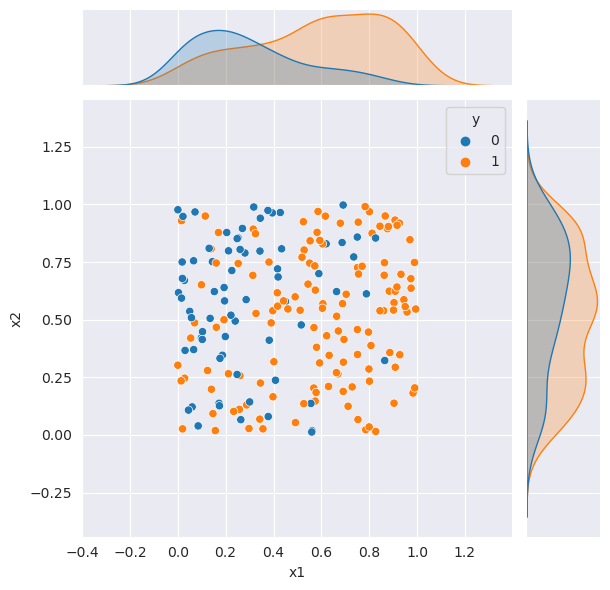

In [24]:
sns.jointplot(data=logistic_df
               , x='x1'
               , y='x2'
               , hue='y'
               )

model = LogisticRegression(fit_intercept = False, penalty = "none").fit(X, y)
model.coef_

In [169]:
[x for x in model.coef_.flatten()] + [model.intercept_[0]]

[4.214455181482938, -1.543577704908252, -0.38797446677310327]

array([1., 1., 1., 1.])

In [242]:
def trial(xs, ys, target_epv, lr_pipe, intercept=False, output_as_df=False, alpha_star=None, trial_num=None):
    
    # create population & hold-out test set
    pop_x, test_x, pop_y, test_y = train_test_split(xs, ys)
    
    # create sample size based on target_epv
    num_vars = len(xs.columns)
    sample_size = int(np.round(target_epv * num_vars))

    # create sample
    pop_ind = pop_x.index
    sample_ind = np.random.choice( pop_x.index
                                 , size=sample_size
                                 , replace=False
                                 )    
    sample_x = pop_x.loc[sample_ind]
    sample_y = pop_y.loc[sample_ind]
    
    # fit population
    lr_pipe.fit( pop_x
               , pop_y.values.ravel()
               )
    pop_coef = get_lr_coef(lr_pipe, intercept)
    pop_score = lr_pipe.score(test_x, test_y)
    
    xprime = lr_pipe[0].transform(pop_x)
    
    if intercept:
        intercept_col = np.ones((len(pop_x), 1))
    else:
        intercept_col = np.zeros((len(pop_x), 1))
    
    
    xprime = np.hstack((xprime, intercept_col))
    
    pop_signal_strength = np.sqrt(np.var(xprime @ pop_coef))
    
    # safety valve for these small sample sizes
    safety_valve = len(sample_y[sample_y.columns[0]].unique()) < 2
    while safety_valve:
        sample_ind = np.random.choice( pop_x.index
                             , size=sample_size
                             , replace=False
                             )    
        sample_x = pop_x.loc[sample_ind]
        sample_y = pop_y.loc[sample_ind]
        safety_valve = len(sample_y[sample_y.columns[0]].unique()) < 2
        
    # don't do the transform steps again for the shorter lists
    fit_lr_only(lr_pipe, sample_x, sample_y.values.ravel())
    sample_coef = get_lr_coef(lr_pipe, intercept)
    sample_score = lr_pipe.score(test_x, test_y)
    
    xprime = lr_pipe[0].transform(sample_x)
    
    sample_signal_strength = np.sqrt(np.var(xprime @ pop_coef[:-1]))
    
    results = { "population_coeff" : pop_coef
              , "population_score" : pop_score
              , "population_epv" : get_epv(pop_x) #len(pop_x) * 1./len(pop_coef.flatten())
              , "population_signal_strength" : pop_signal_strength 
              , "sample_coeff" : sample_coef
              , "sample_score" : sample_score
              , "sample_epv" : get_epv(sample_x) #len(sample_x) * 1./len(pop_coef.flatten())
              , "sample_signal_strength" : sample_signal_strength 
              }
    
    if output_as_df:
        results['population_coeff'] = pop_coef.flatten()
        results['sample_coeff'] = sample_coef.flatten()
        results = pd.DataFrame(results)
        results['coeff_ind'] = np.arange(0, len(results))
        
        if alpha_star is not None:
            if len(alpha_star) != len(sample_coef.flatten()):
                print('could not continue with alpha_star correction, length mismatch')
                return results
            else:
                
                if not intercept:
                    new_sample_coef = np.array([
                        sample_coef[0,i] / alpha_star[i] for i in range(len(alpha_star))
                    ]).reshape(sample_coef.shape)

                    set_lr_coef(lr_pipe, new_sample_coef, intercept=intercept)
                else:
                    new_sample_coef = np.array([
                        sample_coef[i] / alpha_star[i] for i in range(len(alpha_star))
                    ])
                    
                    set_lr_coef(lr_pipe, new_sample_coef, intercept=intercept)
                
                corrected_score = lr_pipe.score(test_x, test_y)
                results['corrected_coeff'] = new_sample_coef.flatten()
                results['corrected_score'] = corrected_score    
                
    if trial_num is not None:
        results['trial_num'] = trial_num
    
    return results

def experiment(n_trials, target_epv, xs, ys, pipeline, seed=None, intercept=False):
    if seed is not None:
        np.random.seed(seed)
        
    # generate
    results = pd.concat([ trial(xs
                               , ys
                               , target_epv
                               , pipeline
                               , intercept=intercept
                               , output_as_df=True
                               , trial_num=n 
                               ) 
                         for n in range(n_trials) 
                        ]).reset_index(drop=True)
    
    
    # analysis
    alpha_star = np.zeros(len(results['coeff_ind'].unique()))
    for coeff, ind_df in results.groupby('coeff_ind'):
        # working space df
        df = ind_df.copy()

        # plot population vs sample beta
        sns.regplot( data=ind_df
                 , x='population_coeff'
                 , y='sample_coeff'
                 )
        plt.show()

        linreg = LinearRegression( fit_intercept=False
                                 ).fit( ind_df['population_coeff'].values.reshape(-1, 1)
                                      , ind_df['sample_coeff'].values
                                      )
        alpha_star[coeff] = linreg.coef_[0]

        df['bias'] = df['sample_coeff'] - df['population_coeff']
        df['correction'] = df['sample_coeff'] - alpha_star[coeff] * df['population_coeff']

        d1 = df.copy()
        d1['corrected'] = False
        d2 = df.copy()
        d2['corrected'] = True
        d2['bias'] = d2['correction']
        df_j = pd.concat([ d1
                         , d2
                         ]
                        , axis=0
                        ).drop(columns=['correction']
                              ).reset_index()

        sns.histplot(data=df_j
                    , x='bias'
                    , hue='corrected'
                    , palette=['red', 'skyblue'] 
                    )
        plt.show()

        sns.jointplot( data=df_j
                     , x='population_coeff'
                     , y='bias'
                     , hue='corrected'
                     , palette=['red', 'skyblue'] 
                     )
        plt.savefig(fname='joint_bias_corr_'+str(coeff)+'.png')
        plt.show()
            
    
    return results, alpha_star

def correction_experiment(n_trials, target_epv, xs, ys, pipeline, alpha_star, intercept=False, seed=None):
    if seed is not None:
        np.random.seed(seed)
        
    results = pd.concat([ trial(xs
                               , ys
                               , target_epv
                               , pipeline
                               , intercept=intercept 
                               , output_as_df=True
                               , alpha_star=alpha_star 
                               , trial_num=n 
                               ) 
                         for n in range(n_trials) 
                        ]).reset_index(drop=True)
    
    result_gb = results.groupby('trial_num').aggregate('mean')[
        ['population_score', 'sample_score', 'corrected_score']
    ]
    
    sns.histplot(data=result_gb, x='population_score', color='blue', label='Population', bins='fd', kde=True)
    sns.histplot(data=result_gb, x='sample_score', color='red', label='Biased Sample', bins='fd', kde=True)
    sns.histplot(data=result_gb, x='corrected_score', color='skyblue', label='Corrected Sample', bins='fd', kde=True)
    plt.xlabel('score')
    plt.legend()
    plt.show()

    return results

In [95]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

In [186]:
def get_epv(df):
    v = len(df.columns)
    e = len(df)
    return e/v

def get_lr_coef(pipe, intercept=False):
    if intercept:
        c = pipe.steps[-1][1].coef_
        i = pipe.steps[-1][1].intercept_[0]
        return np.array(np.array([cc for cc in c.flatten()] + [i]))
    else:
        return pipe.steps[-1][1].coef_

def set_lr_coef(pipe, coef, intercept=False):
    if intercept:
        for c in range(len(coef) - 1):
            pipe.steps[-1][1].coef_[0,c] = coef[c]
        pipe.steps[-1][1].intercept_[0] = coef[-1]
    else:
        pipe.steps[-1][1].coef_ = coef

    
def fit_lr_only(pipe, xs, ys):
    transformed_xs = pipe.steps[0][1].transform(xs)
    pipe.steps[-1][1].fit(transformed_xs, ys)

In [152]:
xs = logistic_df[['x1', 'x2']]
ys = logistic_df[['y']]

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# preproc = ColumnTransformer(
#     transformers = [ ("num", numeric_transformer, numeric_features)
#                    , ("cat", categorical_transformer, [x for x in categorical_features if x != ys_col])
#                    ]
# )

pipe = Pipeline(steps=[ ("preprocessor", numeric_transformer)
                          , ("classifier", LogisticRegression( fit_intercept=False))
                          ]
                   )

pipe_int = Pipeline(steps=[ ("preprocessor", numeric_transformer)
                          , ("classifier", LogisticRegression( fit_intercept=True))
                          ]
                   )


In [138]:
np.random.choice(ys['y'], 5)

array([1, 1, 1, 1, 1])

In [171]:
res = trial(xs, ys, 15, pipe, output_as_df=True)
res

,population_coeff,population_score,population_epv,sample_coeff,sample_score,sample_epv,coeff_ind
0,1.132726,0.68,75.0,1.397009,0.68,15.0,0
1,-0.347909,0.68,75.0,-0.318925,0.68,15.0,1


In [231]:
res = trial(xs, ys, 15, pipe_int, intercept=True, output_as_df=False)
res

array([[-8.99957748e-01,  1.50149439e-01,  1.00000000e+00],
       [ 9.58995936e-01,  5.57855852e-01,  1.00000000e+00],
       [ 4.99603149e-01,  1.43462616e+00,  1.00000000e+00],
       [-1.04198304e+00,  2.91459316e-01,  1.00000000e+00],
       [-7.25226987e-01,  1.09453597e+00,  1.00000000e+00],
       [ 9.45245245e-01, -6.61993103e-01,  1.00000000e+00],
       [ 2.57894706e-01,  4.04413837e-01,  1.00000000e+00],
       [ 3.96569531e-01,  1.50652406e+00,  1.00000000e+00],
       [-1.32876112e+00, -5.87976534e-01,  1.00000000e+00],
       [-7.10833932e-01,  1.10580681e+00,  1.00000000e+00],
       [-1.10041859e+00, -1.14310707e-01,  1.00000000e+00],
       [-1.13664366e+00, -9.05553720e-01,  1.00000000e+00],
       [-4.02569817e-01, -1.09471447e+00,  1.00000000e+00],
       [-6.00524322e-01,  1.69275280e-01,  1.00000000e+00],
       [ 1.10691789e+00, -1.76015100e+00,  1.00000000e+00],
       [ 1.13179660e+00, -5.25871347e-01,  1.00000000e+00],
       [-1.67808778e-01,  2.73567614e-01

In [206]:
# df, alpha_star = experiment(1000, 5.0, xs, ys, pipe, seed=12345)

In [207]:
# corr_df = correction_experiment(1000, 5.0, xs, ys, pipe, alpha_star, seed=12345)

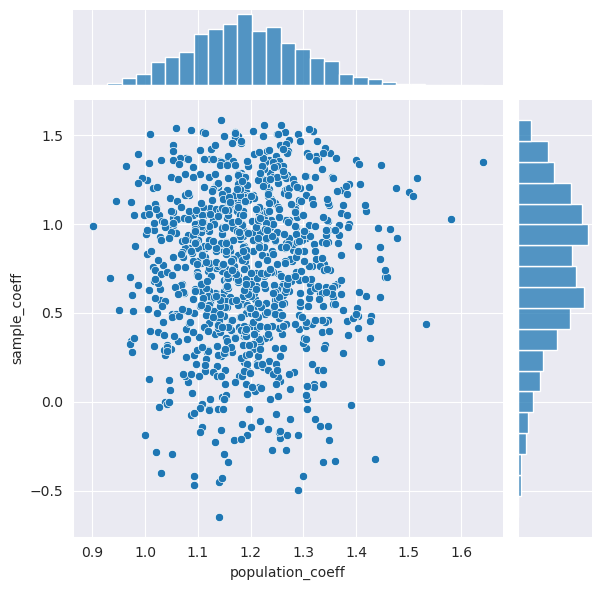

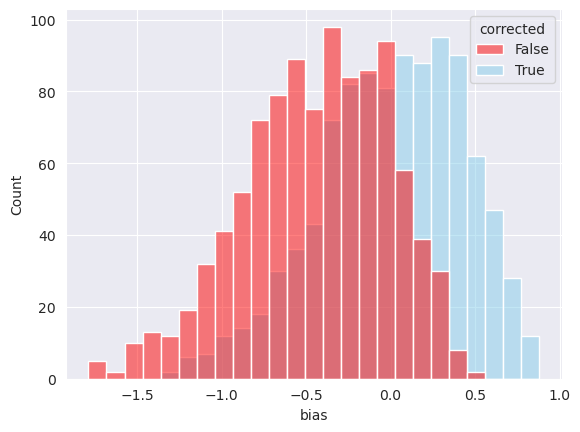

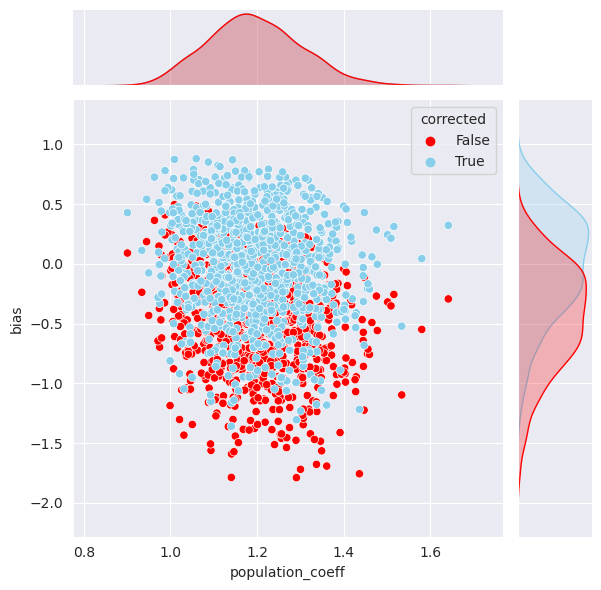

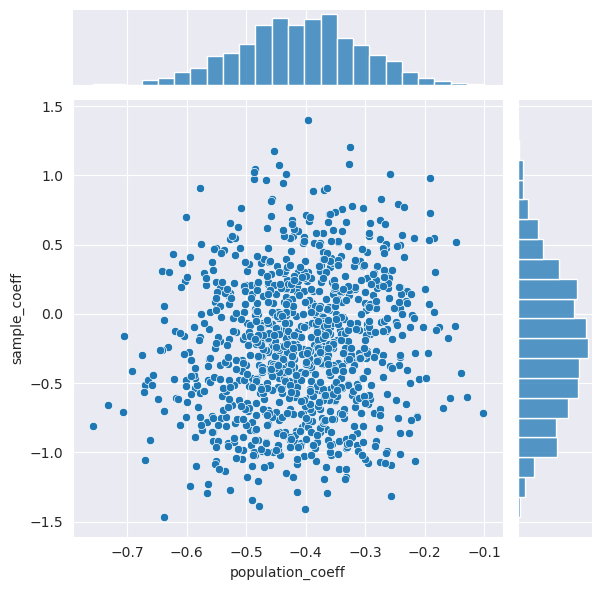

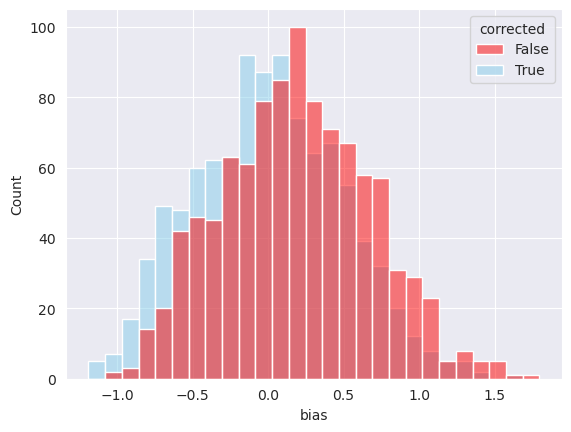

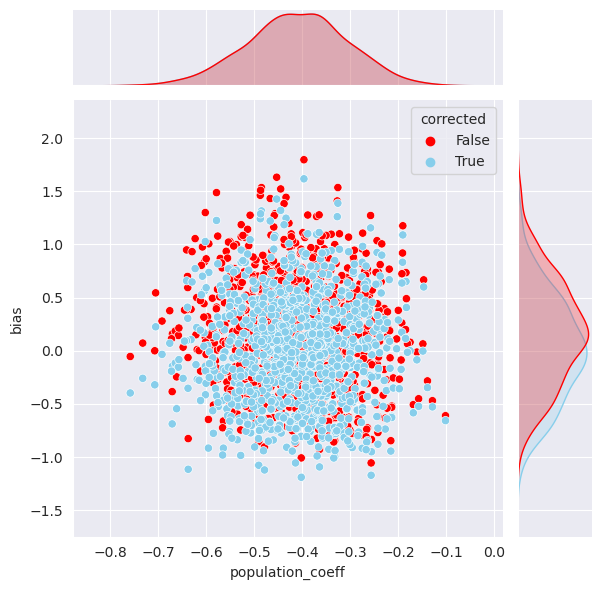

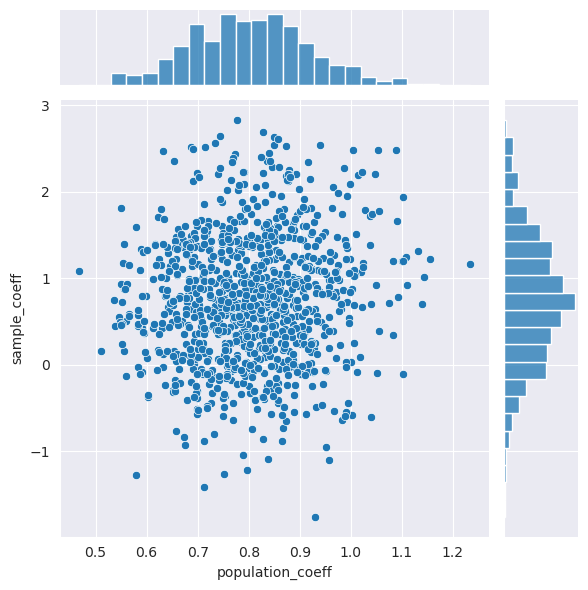

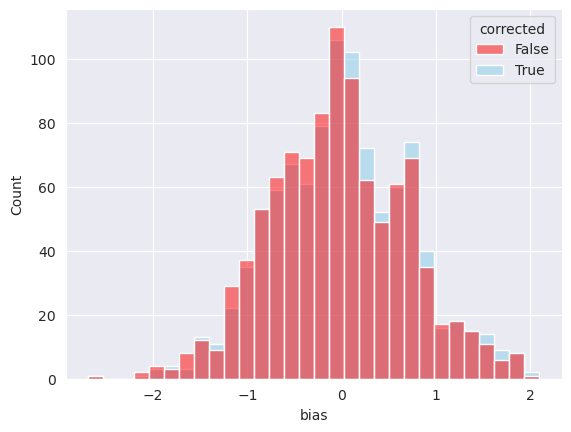

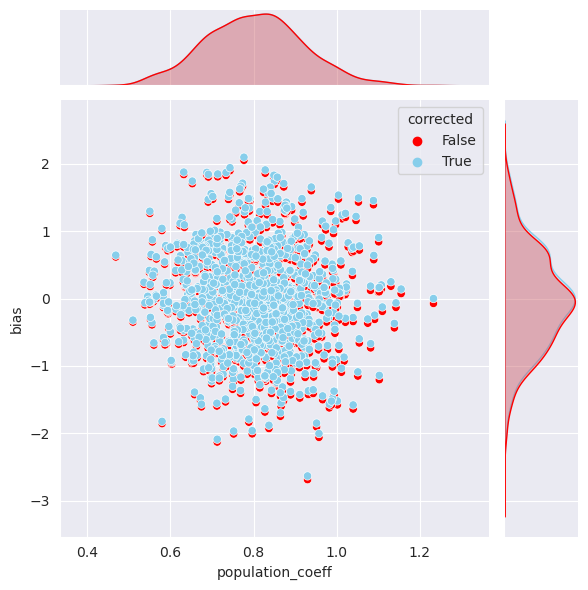

In [210]:
# df, alpha_star = experiment(1000, 5.0, xs, ys, pipe_int,  seed=12345, intercept=True,)

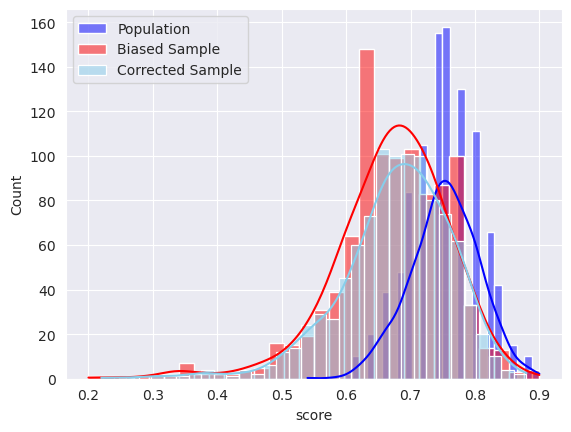

In [211]:
# corr_df = correction_experiment(1000, 5.0, xs, ys, pipe_int, alpha_star, seed=87533, intercept=True,)

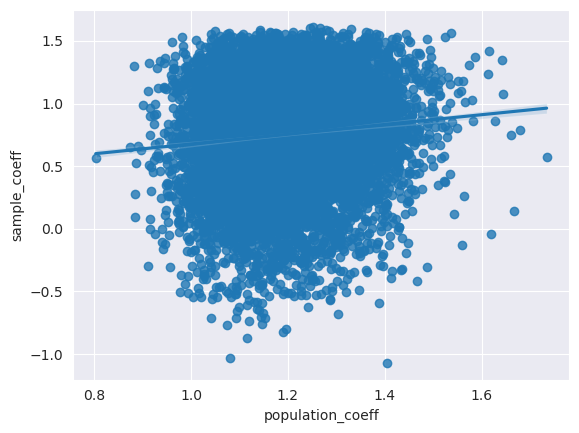

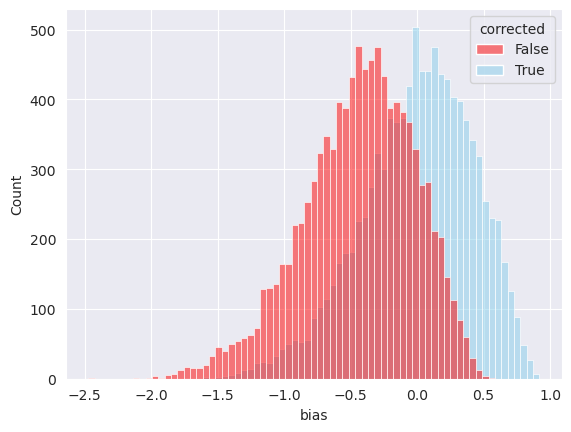

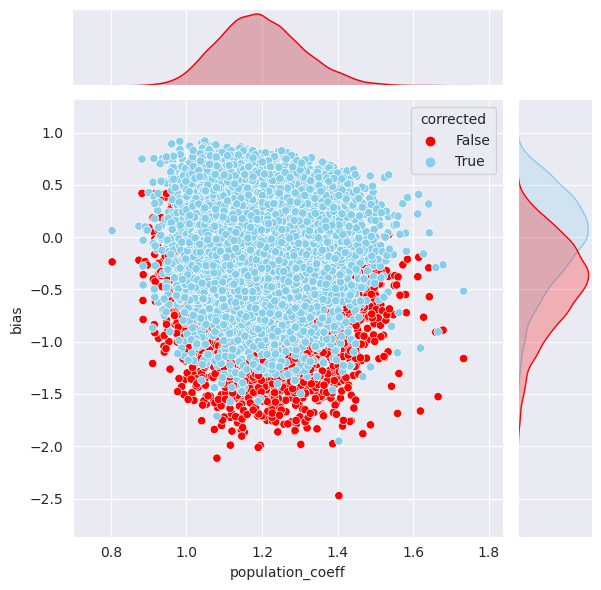

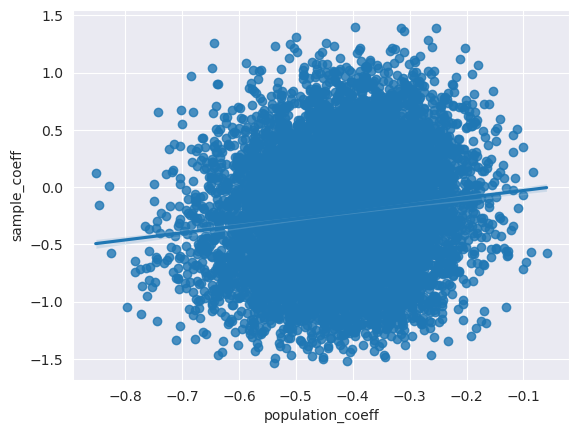

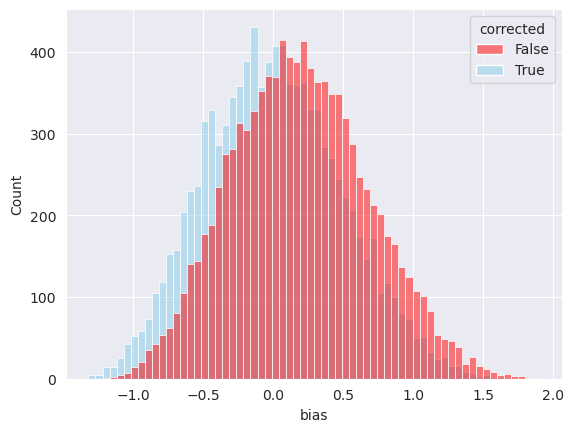

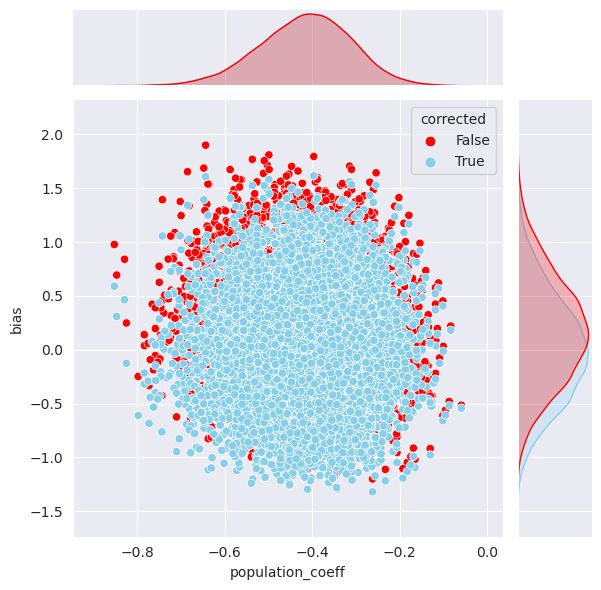

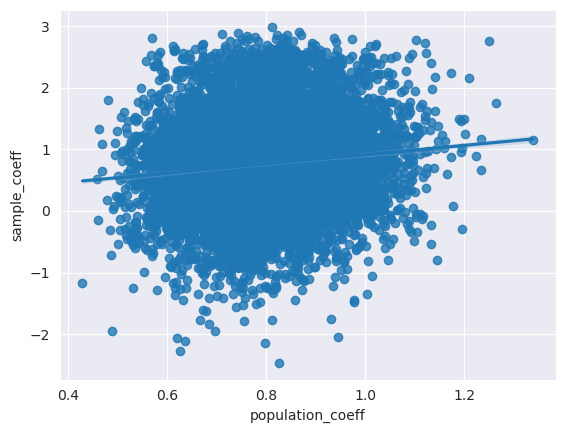

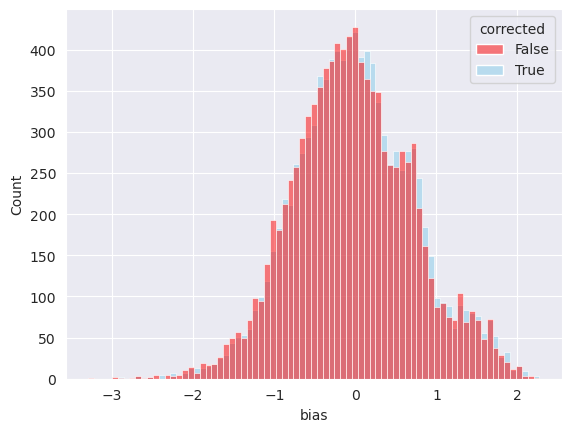

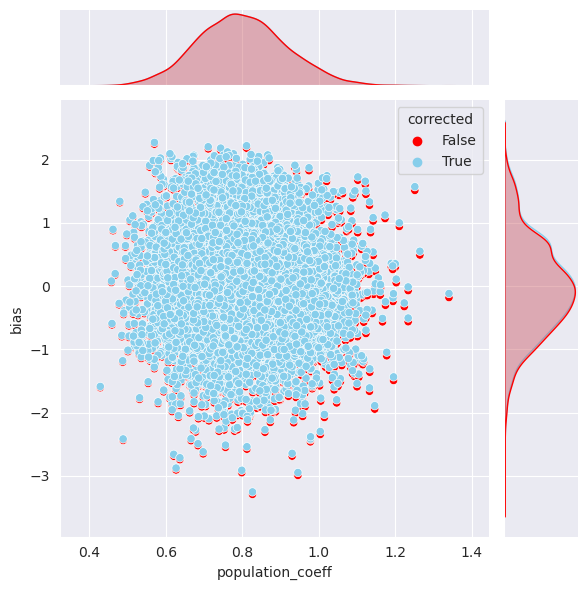

In [243]:
df, alpha_star = experiment(10000, 5.0, xs, ys, pipe_int,  seed=12345, intercept=True,)

In [244]:
alpha_star

array([0.6280801 , 0.54519287, 0.9525728 ])

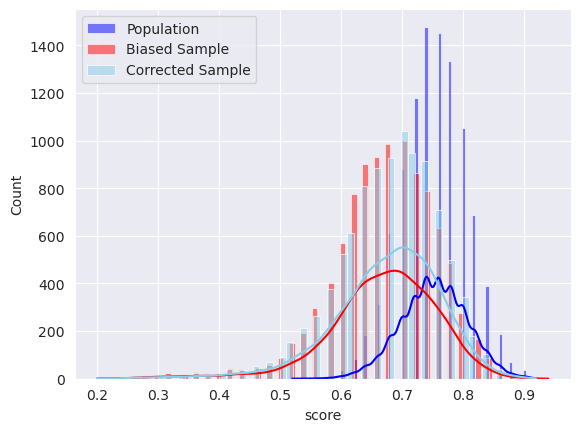

In [233]:
# corr_df = correction_experiment(10000, 5.0, xs, ys, pipe_int, alpha_star, seed=12345, intercept=True,)

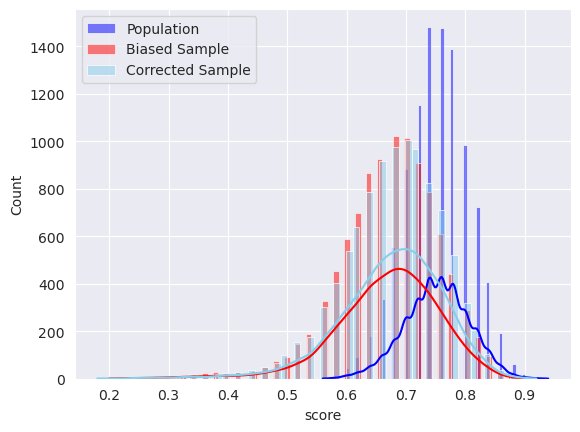

In [253]:
corr_df = correction_experiment(10000, 5.0, xs, ys, pipe_int, alpha_star, intercept=True,)

<AxesSubplot:>

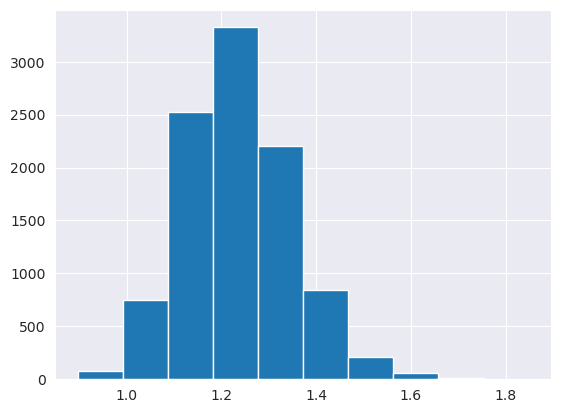

In [254]:
corr_df.groupby('trial_num').mean()['population_signal_strength'].hist()

In [255]:
corr_df.groupby('trial_num').mean()

,population_coeff,population_score,population_epv,population_signal_strength,sample_coeff,sample_score,sample_epv,sample_signal_strength,coeff_ind,corrected_coeff,corrected_score
trial_num,,,,,,,,,,,
0,0.431592,0.74,75.0,1.222390,0.339903,0.70,5.0,1.203589,1.0,0.276174,0.70
1,0.486124,0.82,75.0,1.056139,1.028411,0.62,5.0,0.992472,1.0,1.338257,0.72
2,0.585859,0.74,75.0,1.266915,0.448335,0.70,5.0,1.340069,1.0,0.569129,0.76
3,0.465233,0.74,75.0,1.306284,0.622453,0.76,5.0,1.190142,1.0,0.855879,0.76
4,0.449040,0.82,75.0,1.077275,0.594011,0.70,5.0,1.107087,1.0,0.775424,0.74
...,...,...,...,...,...,...,...,...,...,...,...
9995,0.474525,0.82,75.0,1.050292,0.278047,0.74,5.0,0.980059,1.0,0.438359,0.74
9996,0.537626,0.76,75.0,1.099946,-0.257649,0.44,5.0,1.075731,1.0,-0.311325,0.34
9997,0.480363,0.78,75.0,1.233135,0.837157,0.70,5.0,1.315187,1.0,0.801109,0.74


Text(0.5, 0, 'signal strength')

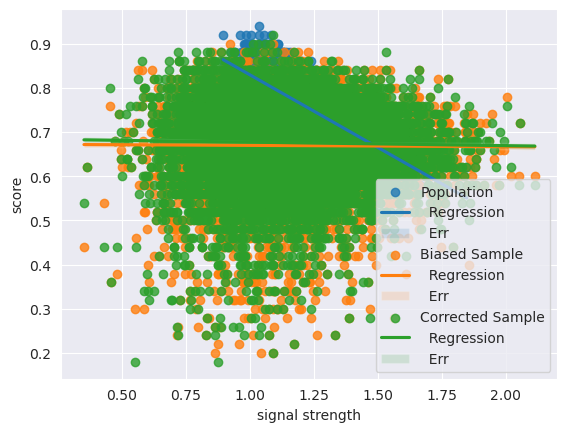

In [256]:
sns.regplot( data=corr_df.groupby('trial_num').mean()
             , x='population_signal_strength'
             , y='population_score')
sns.regplot( data=corr_df.groupby('trial_num').mean()
             , x='sample_signal_strength'
             , y='sample_score')
sns.regplot( data=corr_df.groupby('trial_num').mean()
             , x='sample_signal_strength'
             , y='corrected_score')
plt.legend(['Population', '  Regression', '  Err', 'Biased Sample', '  Regression', '  Err',
            'Corrected Sample',  '  Regression', '  Err',])
plt.ylabel('score')
plt.xlabel('signal strength')

<AxesSubplot:xlabel='population_signal_strength', ylabel='population_score'>

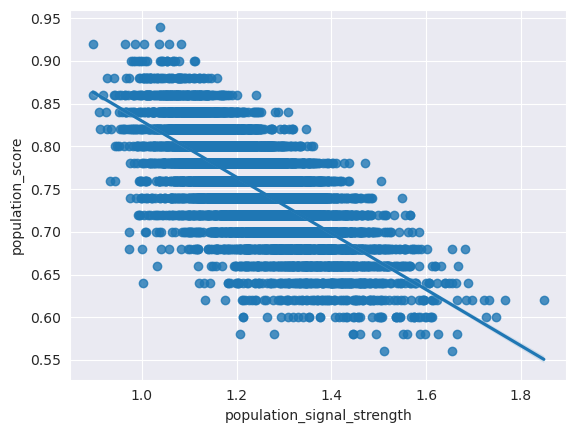

In [257]:
sns.regplot( data=corr_df.groupby('trial_num').mean()
             , x='population_signal_strength'
             , y='population_score')

<AxesSubplot:xlabel='population_signal_strength', ylabel='sample_score'>

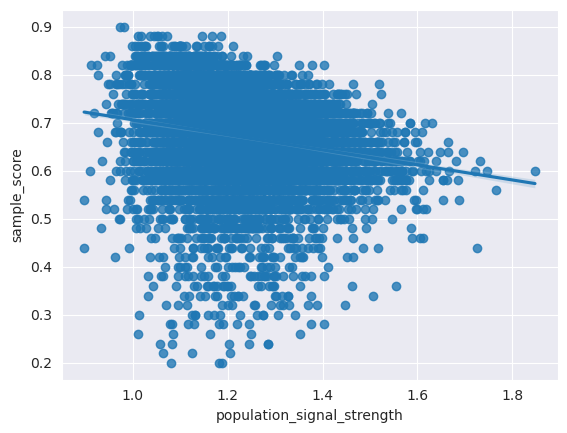

In [258]:
sns.regplot( data=corr_df.groupby('trial_num').mean()
             , x='population_signal_strength'
             , y='sample_score')

In [293]:
def signal_strength_sample_corr(df):
    lr = LinearRegression().fit(df[['population_signal_strength']], df['sample_score'])
    my_str =  "y = {:.4}x + {:.4}".format(lr.coef_[0], lr.intercept_)
#     plt.text(7.7, 0.705, my_str)
    plt.title(my_str)
    sns.regplot( data=df.groupby('trial_num').mean()
             , x='sample_signal_strength'
             , y='sample_score'
               )

    plt.show()
    return lr.coef_[0], lr.intercept_

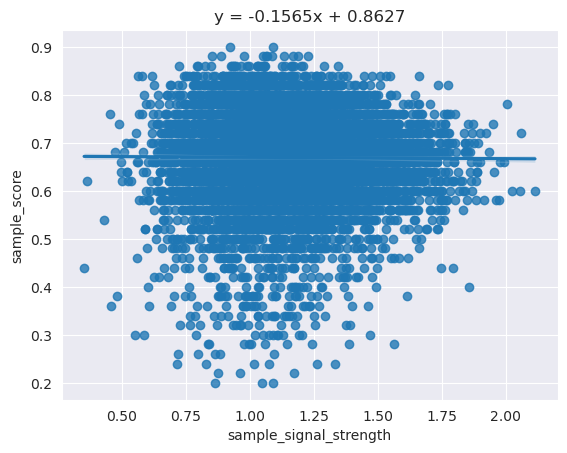

(-0.15651087176112372, 0.8626947924557832)

In [294]:
signal_strength_sample_corr(corr_df)

<AxesSubplot:xlabel='population_signal_strength', ylabel='corrected_score'>

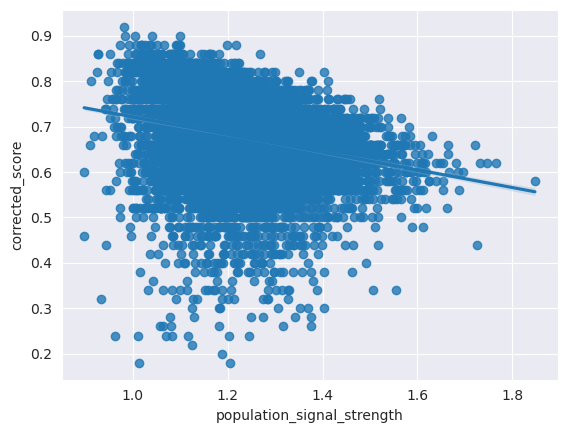

In [259]:
sns.regplot( data=corr_df.groupby('trial_num').mean()
             , x='population_signal_strength'
             , y='corrected_score')

<AxesSubplot:xlabel='sample_signal_strength', ylabel='sample_score'>

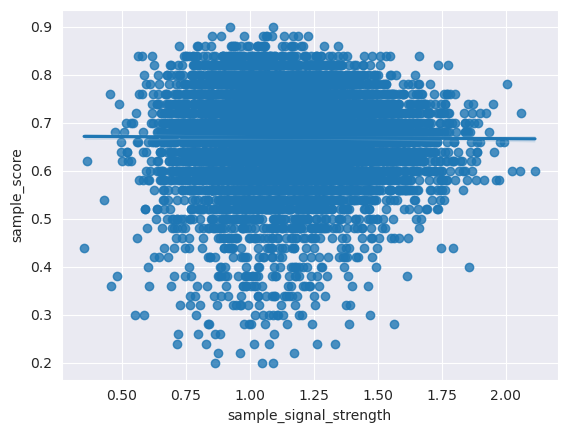

In [262]:
sns.regplot( data=corr_df.groupby('trial_num').mean()
             , x='sample_signal_strength'
             , y='sample_score')

In [260]:
corr_df

,population_coeff,population_score,population_epv,population_signal_strength,sample_coeff,sample_score,sample_epv,sample_signal_strength,coeff_ind,corrected_coeff,corrected_score,trial_num
0,1.127476,0.74,75.0,1.222390,0.948197,0.70,5.0,1.203589,0,1.509676,0.70,0
1,-0.599250,0.74,75.0,1.222390,-0.964051,0.70,5.0,1.203589,1,-1.768275,0.70,0
2,0.766551,0.74,75.0,1.222390,1.035562,0.70,5.0,1.203589,2,1.087121,0.70,0
3,1.014318,0.82,75.0,1.056139,1.055371,0.62,5.0,0.992472,0,1.680312,0.72,1
4,-0.417043,0.82,75.0,1.056139,0.259465,0.62,5.0,0.992472,1,0.475914,0.72,1
...,...,...,...,...,...,...,...,...,...,...,...,...
29995,-0.506171,0.76,75.0,1.166444,0.661322,0.66,5.0,0.861311,1,1.213006,0.64,9998
29996,0.900971,0.76,75.0,1.166444,0.988452,0.66,5.0,0.861311,2,1.037665,0.64,9998
29997,1.095987,0.82,75.0,1.139742,1.066940,0.74,5.0,1.304507,0,1.698732,0.78,9999
29998,-0.359591,0.82,75.0,1.139742,-0.610563,0.74,5.0,1.304507,1,-1.119902,0.78,9999


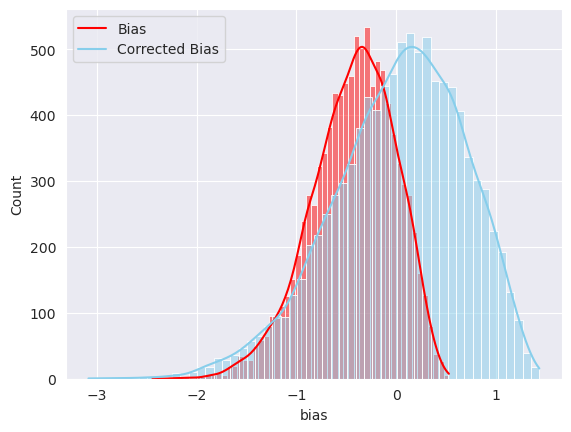

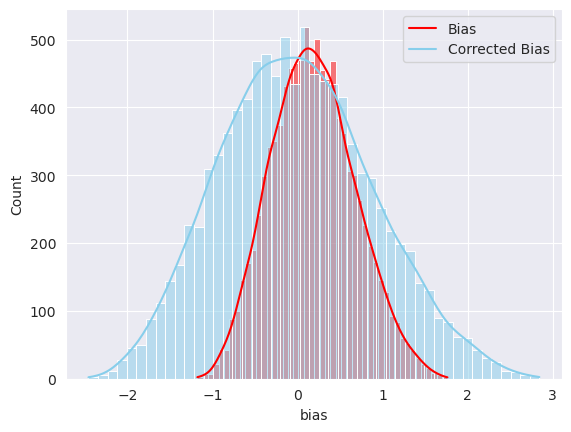

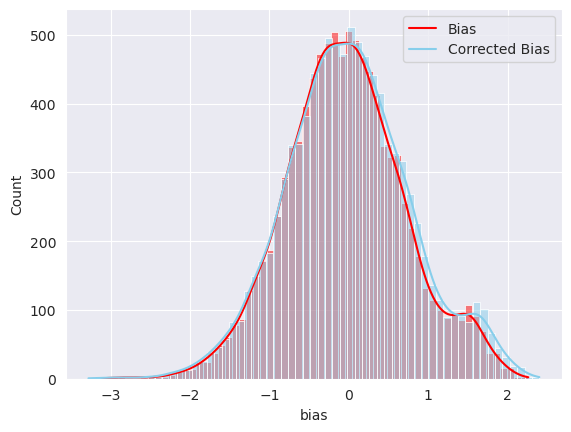

In [261]:
for ci, ci_df in corr_df.groupby('coeff_ind'):
    ci_df['bias'] = ci_df['sample_coeff'] - ci_df['population_coeff']
    ci_df['correction'] = ci_df['corrected_coeff'] - ci_df['population_coeff']
    sns.histplot(data=ci_df, x='bias', color='red', kde=True)
    sns.histplot(data=ci_df, x='correction', color='skyblue', kde=True)
    plt.legend(['Bias', 'Corrected Bias'])
    plt.show()